In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [3]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [4]:
from torch_utility import *

## Import Dataset

In [5]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [6]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [7]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.10, random_state=42)

In [8]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1371, 10)
(1371, 2)
(153, 10)
(153, 2)


In [9]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [10]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [11]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [12]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

In [13]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
import time

begin = time.time()

total = []
for i in range(0,10):
    test_net = Net(100, 50, torch.sigmoid)
    nett = NeuralNetRegressor(test_net, max_epochs=1000,
                              lr=0.006,
                              batch_size=64,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.8,
                              optimizer__weight_decay=0.0001,
                              optimizer__nesterov = True,
                              criterion=MEE,
    #                           callbacks=[EarlyStopping(patience=100)]
                             )
    # Training
    nett.fit(Xtrain, ytrain)

    prova = nett.predict(Xval)
    ris = mean_euclidean_error(prova, yval)
    total.append(ris)

end = time.time()
print(str(begin-end) + ' Seconds')

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.9415       49.7207  0.1534
      2       44.7833       35.1040  0.1399
      3       27.8234       20.0048  0.1187
      4       18.4343       16.5084  0.1114
      5       16.3020       15.5316  0.1001
      6       15.4732       14.7017  0.1990
      7       14.4736       13.4182  0.1858
      8       12.9661       11.6084  0.2065
      9       11.1134        9.8092  0.1395
     10        9.5859        8.6958  0.1615
     11        8.8953        8.3956  0.1528
     12        8.7063        8.3460  0.1940
     13        8.6406        8.3295  0.1223
     14        8.6061        8.3122  0.1385
     15        8.5793        8.2913  0.1629
     16        8.5552        8.2697  0.1437
     17        8.5327        8.2487  0.1388
     18        8.5112        8.2269  0.1523
     19        8.4901        8.2048  0.1563
     20        8.4688        8.1823  0.1314
     21        8.4468        8.1

    133        3.1279        3.2127  0.1421
    134        3.1241        3.2095  0.1381
    135        3.1204        3.2064  0.1082
    136        3.1167        3.2033  0.1101
    137        3.1131        3.2003  0.0886
    138        3.1094        3.1973  0.1137
    139        3.1058        3.1944  0.1359
    140        3.1022        3.1915  0.1144
    141        3.0987        3.1886  0.1558
    142        3.0951        3.1858  0.1094
    143        3.0915        3.1830  0.1572
    144        3.0880        3.1802  0.1040
    145        3.0844        3.1774  0.1072
    146        3.0809        3.1747  0.1124
    147        3.0774        3.1719  0.1152
    148        3.0740        3.1690  0.1206
    149        3.0706        3.1661  0.1601
    150        3.0670        3.1610  0.1325
    151        3.0635        3.1599  0.1075
    152        3.0607        3.1584  0.1160
    153        3.0579        3.1574  0.1520
    154        3.0548        3.1534  0.1009
    155        3.0514        3.1

    267        2.8172        2.9939  0.1466
    268        2.8140        2.9936  0.1216
    269        2.8137        2.9965  0.1228
    270        2.8120        2.9922  0.0954
    271        2.8106        2.9927  0.1366
    272        2.8092        2.9928  0.1559
    273        2.8080        2.9927  0.0937
    274        2.8067        2.9920  0.1193
    275        2.8055        2.9911  0.0913
    276        2.8043        2.9904  0.0968
    277        2.8031        2.9898  0.1026
    278        2.8019        2.9891  0.0996
    279        2.8007        2.9884  0.1107
    280        2.7995        2.9877  0.1008
    281        2.7984        2.9869  0.1007
    282        2.7972        2.9858  0.0933
    283        2.7961        2.9843  0.1007
    284        2.7950        2.9844  0.1325
    285        2.7939        2.9868  0.1013
    286        2.7926        2.9886  0.1554
    287        2.7918        2.9923  0.1234
    288        2.7916        2.9780  0.1996
    289        2.7884        2.9

    426        2.6734        2.9506  0.1079
    427        2.6729        2.9296  0.1121
    428        2.6716        2.9332  0.1156
    429        2.6719        2.9483  0.0994
    430        2.6710        2.9281  0.1111
    431        2.6692        2.9316  0.1578
    432        2.6697        2.9482  0.1018
    433        2.6683        2.9276  0.1103
    434        2.6676        2.9308  0.1161
    435        2.6681        2.9460  0.1679
    436        2.6665        2.9266  0.1341
    437        2.6654        2.9297  0.0980
    438        2.6658        2.9458  0.1616
    439        2.6641        2.9262  0.1187
    440        2.6638        2.9289  0.1145
    441        2.6641        2.9445  0.1138
    442        2.6621        2.9255  0.0835
    443        2.6618        2.9275  0.0837
    444        2.6624        2.9434  0.0998
    445        2.6600        2.9250  0.0983
    446        2.6600        2.9266  0.0983
    447        2.6608        2.9423  0.0995
    448        2.6579        2.9

    590        2.5835        2.9013  0.1279
    591        2.5847        2.9067  0.1347
    592        2.5850        2.9224  0.1445
    593        2.5889        2.8897  0.1210
    594        2.5820        2.9041  0.1473
    595        2.5851        2.8961  0.1499
    596        2.5824        2.9194  0.1395
    597        2.5846        2.8988  0.1438
    598        2.5804        2.9062  0.1216
    599        2.5826        2.9232  0.1143
    600        2.5889        2.8987  0.1214
    601        2.5822        2.9087  0.0831
    602        2.5833        2.8937  0.1041
    603        2.5789        2.8950  0.0902
    604        2.5793        2.9155  0.1259
    605        2.5824        2.9099  0.0780
    606        2.5770        2.8960  0.1387
    607        2.5765        2.9005  0.1513
    608        2.5766        2.9078  0.0706
    609        2.5874        2.8917  0.0756
    610        2.5774        2.9215  0.1045
    611        2.5834        2.8923  0.0976
    612        2.5741        2.9

    767        2.5279        2.9042  0.2167
    768        2.5291        2.8850  0.1939
    769        2.5215        2.8930  0.1076
    770        2.5217        2.8832  0.1046
    771        2.5204        2.9021  0.1039
    772        2.5341        2.8958  0.1327
    773        2.5269        2.9009  0.3229
    774        2.5265        2.8882  0.2798
    775        2.5201        2.8927  0.3435
    776        2.5198        2.8844  0.2717
    777        2.5191        2.8972  0.4499
    778        2.5294        2.8989  0.1782
    779        2.5252        2.9015  0.1885
    780        2.5257        2.8878  0.2094
    781        2.5187        2.8921  0.0879
    782        2.5181        2.8834  0.1049
    783        2.5168        2.9017  0.1833
    784        2.5302        2.8872  0.1038
    785        2.5206        2.8989  0.1334
    786        2.5232        2.8826  0.1800
    787        2.5153        2.8888  0.0876
    788        2.5154        2.8854  0.1078
    789        2.5155        2.8

    944        2.4766        2.8946  0.1733
    945        2.4741        2.9001  0.1019
    946        2.4745        2.8957  0.1422
    947        2.4725        2.8963  0.1195
    948        2.4727        2.8898  0.1348
    949        2.4742        2.8984  0.0985
    950        2.4739        2.8942  0.1127
    951        2.4705        2.8934  0.0915
    952        2.4739        2.8937  0.3161
    953        2.4707        2.8994  0.2440
    954        2.4740        2.9037  0.2355
    955        2.4709        2.8933  0.0982
    956        2.4709        2.9015  0.1417
    957        2.4705        2.9034  0.1008
    958        2.4782        2.9004  0.1246
    959        2.4721        2.9006  0.3203
    960        2.4748        2.9093  0.1945
    961        2.4744        2.9052  0.1126
    962        2.4768        2.9002  0.0984
    963        2.4671        2.8984  0.1329
    964        2.4720        2.9023  0.1537
    965        2.4685        2.8965  0.1018
    966        2.4725        2.8

     90        3.3823        3.4334  0.2537
     91        3.3734        3.4258  0.1990
     92        3.3650        3.4152  0.1578
     93        3.3565        3.4068  0.1297
     94        3.3484        3.3984  0.1052
     95        3.3404        3.3906  0.1633
     96        3.3327        3.3831  0.1289
     97        3.3254        3.3759  0.2175
     98        3.3184        3.3691  0.0856
     99        3.3115        3.3625  0.1019
    100        3.3048        3.3559  0.0778
    101        3.2982        3.3495  0.1492
    102        3.2919        3.3433  0.1550
    103        3.2856        3.3373  0.1729
    104        3.2795        3.3315  0.2035
    105        3.2735        3.3259  0.1554
    106        3.2678        3.3207  0.1360
    107        3.2623        3.3160  0.1063
    108        3.2570        3.3116  0.1708
    109        3.2519        3.3076  0.1342
    110        3.2469        3.3042  0.1025
    111        3.2420        3.3015  0.1183
    112        3.2373        3.2

    225        2.9210        3.0690  0.1172
    226        2.9192        3.0679  0.2574
    227        2.9174        3.0669  0.1122
    228        2.9156        3.0660  0.0993
    229        2.9138        3.0650  0.1886
    230        2.9121        3.0642  0.1063
    231        2.9102        3.0635  0.0968
    232        2.9084        3.0627  0.1889
    233        2.9067        3.0617  0.1894
    234        2.9049        3.0607  0.2200
    235        2.9031        3.0597  0.1174
    236        2.9014        3.0586  0.1853
    237        2.8997        3.0575  0.1796
    238        2.8980        3.0564  0.1015
    239        2.8963        3.0553  0.1009
    240        2.8947        3.0543  0.0977
    241        2.8931        3.0533  0.1586
    242        2.8914        3.0523  0.1423
    243        2.8898        3.0513  0.1520
    244        2.8883        3.0503  0.1225
    245        2.8867        3.0493  0.1288
    246        2.8851        3.0484  0.2079
    247        2.8836        3.0

    359        2.7519        2.9972  0.1186
    360        2.7515        2.9886  0.1491
    361        2.7487        3.0024  0.1423
    362        2.7502        2.9918  0.1121
    363        2.7469        2.9872  0.1066
    364        2.7472        2.9901  0.1114
    365        2.7416        2.9852  0.0982
    366        2.7468        2.9886  0.1142
    367        2.7393        2.9838  0.0998
    368        2.7454        2.9893  0.1136
    369        2.7375        2.9833  0.1050
    370        2.7438        2.9908  0.0927
    371        2.7360        2.9824  0.2240
    372        2.7419        2.9895  0.2293
    373        2.7339        2.9816  0.2072
    374        2.7392        2.9861  0.2126
    375        2.7316        2.9807  0.1462
    376        2.7379        2.9879  0.1291
    377        2.7301        2.9870  0.1301
    378        2.7362        3.0001  0.2090
    379        2.7353        2.9988  0.1040
    380        2.7343        2.9868  0.1896
    381        2.7292        2.9

    525        2.6282        2.9512  0.1238
    526        2.6315        2.9584  0.0970
    527        2.6341        2.9301  0.1084
    528        2.6265        2.9343  0.1429
    529        2.6269        2.9544  0.0948
    530        2.6343        2.9342  0.1607
    531        2.6253        2.9472  0.1592
    532        2.6284        2.9569  0.1895
    533        2.6310        2.9278  0.1318
    534        2.6235        2.9449  0.2170
    535        2.6306        2.9419  0.1758
    536        2.6228        2.9413  0.1464
    537        2.6263        2.9535  0.0881
    538        2.6286        2.9271  0.1402
    539        2.6209        2.9286  0.1055
    540        2.6212        2.9571  0.1278
    541        2.6283        2.9312  0.1192
    542        2.6199        2.9385  0.1376
    543        2.6252        2.9371  0.0967
    544        2.6183        2.9238  0.1349
    545        2.6191        2.9454  0.1227
    546        2.6257        2.9405  0.1499
    547        2.6176        2.9

    696        2.5645        2.9141  0.1149
    697        2.5551        2.9040  0.1432
    698        2.5574        2.9145  0.0788
    699        2.5528        2.9166  0.0917
    700        2.5595        2.9110  0.0635
    701        2.5516        2.9081  0.0746
    702        2.5524        2.9576  0.0766
    703        2.5613        2.8995  0.0757
    704        2.5505        2.9045  0.0797
    705        2.5505        2.9134  0.0771
    706        2.5553        2.9037  0.0830
    707        2.5520        2.9279  0.2813
    708        2.5481        2.9003  0.3263
    709        2.5489        2.9222  0.2776
    710        2.5477        2.9067  0.1191
    711        2.5520        2.9022  0.1881
    712        2.5468        2.8992  0.1216
    713        2.5484        2.9178  0.1388
    714        2.5516        2.9160  0.1382
    715        2.5456        2.9031  0.1517
    716        2.5450        2.8990  0.1687
    717        2.5454        2.9178  0.1015
    718        2.5451        2.8

    867        2.4992        2.9131  0.1219
    868        2.4978        2.8869  0.0910
    869        2.4904        2.8855  0.0647
    870        2.4898        2.8951  0.1271
    871        2.4892        2.8864  0.0876
    872        2.4913        2.8984  0.1069
    873        2.4914        2.8815  0.1053
    874        2.4888        2.8904  0.0918
    875        2.4883        2.8874  0.0966
    876        2.4933        2.8949  0.0807
    877        2.4889        2.8837  0.1354
    878        2.4854        2.8879  0.1015
    879        2.4877        2.9115  0.1227
    880        2.4899        2.8837  0.0699
    881        2.4880        2.9107  0.0975
    882        2.4944        2.8844  0.0832
    883        2.4885        2.8901  0.0932
    884        2.4839        2.8917  0.1067
    885        2.4857        2.8855  0.0926
    886        2.4842        2.8895  0.0785
    887        2.4883        2.8898  0.2023
    888        2.4834        2.8884  0.1159
    889        2.4835        2.9

     29        8.1996        7.8996  0.1344
     30        8.1473        7.8465  0.1347
     31        8.0879        7.7865  0.0962
     32        8.0204        7.7188  0.1244
     33        7.9438        7.6426  0.1678
     34        7.8571        7.5566  0.1281
     35        7.7593        7.4600  0.0925
     36        7.6498        7.3526  0.1355
     37        7.5282        7.2345  0.1122
     38        7.3941        7.1064  0.1024
     39        7.2480        6.9680  0.1042
     40        7.0900        6.8183  0.1457
     41        6.9203        6.6585  0.1089
     42        6.7398        6.4888  0.0993
     43        6.5508        6.3107  0.1212
     44        6.3539        6.1245  0.0956
     45        6.1502        5.9326  0.1589
     46        5.9398        5.7325  0.1373
     47        5.7211        5.5259  0.1050
     48        5.4944        5.3104  0.1157
     49        5.2603        5.0887  0.1011
     50        5.0255        4.8692  0.1330
     51        4.8026        4.6

    163        3.0214        3.1348  0.0991
    164        3.0188        3.1328  0.1019
    165        3.0163        3.1308  0.1384
    166        3.0137        3.1288  0.1575
    167        3.0112        3.1268  0.1934
    168        3.0087        3.1249  0.0834
    169        3.0063        3.1230  0.1071
    170        3.0039        3.1211  0.0810
    171        3.0013        3.1190  0.0930
    172        2.9992        3.1174  0.1028
    173        2.9970        3.1156  0.1141
    174        2.9943        3.1136  0.1082
    175        2.9923        3.1121  0.1366
    176        2.9899        3.1102  0.0939
    177        2.9876        3.1087  0.0868
    178        2.9845        3.1068  0.0920
    179        2.9828        3.1052  0.1001
    180        2.9800        3.1034  0.1146
    181        2.9781        3.1019  0.1184
    182        2.9756        3.1002  0.1342
    183        2.9736        3.0987  0.0759
    184        2.9713        3.0971  0.0922
    185        2.9693        3.0

    297        2.7952        2.9959  0.1314
    298        2.7947        2.9953  0.1620
    299        2.7930        2.9952  0.0940
    300        2.7922        2.9950  0.1077
    301        2.7910        2.9943  0.1513
    302        2.7898        2.9938  0.1641
    303        2.7885        2.9937  0.1463
    304        2.7874        2.9942  0.0928
    305        2.7868        2.9938  0.0983
    306        2.7853        2.9931  0.1713
    307        2.7842        2.9920  0.1220
    308        2.7825        2.9918  0.1292
    309        2.7817        2.9916  0.0948
    310        2.7805        2.9913  0.1096
    311        2.7794        2.9911  0.1220
    312        2.7782        2.9908  0.0987
    313        2.7772        2.9905  0.1051
    314        2.7761        2.9900  0.1470
    315        2.7750        2.9895  0.0960
    316        2.7738        2.9892  0.0762
    317        2.7728        2.9888  0.1231
    318        2.7717        2.9882  0.1177
    319        2.7706        2.9

    455        2.6689        2.9371  0.1033
    456        2.6690        2.9222  0.1323
    457        2.6669        2.9319  0.0910
    458        2.6669        2.9435  0.1302
    459        2.6674        2.9300  0.1730
    460        2.6658        2.9312  0.1065
    461        2.6661        2.9309  0.1168
    462        2.6662        2.9345  0.0879
    463        2.6643        2.9362  0.1132
    464        2.6641        2.9206  0.1154
    465        2.6628        2.9378  0.1170
    466        2.6670        2.9348  0.0956
    467        2.6623        2.9265  0.0966
    468        2.6615        2.9268  0.1687
    469        2.6613        2.9310  0.1110
    470        2.6635        2.9299  0.1064
    471        2.6595        2.9372  0.1162
    472        2.6604        2.9170  0.1611
    473        2.6583        2.9383  0.1440
    474        2.6665        2.9298  0.1223
    475        2.6577        2.9273  0.1563
    476        2.6576        2.9247  0.1178
    477        2.6570        2.9

    619        2.5943        2.8953  0.1260
    620        2.5934        2.9189  0.1499
    621        2.5975        2.8938  0.1387
    622        2.5915        2.8895  0.1086
    623        2.5913        2.8941  0.1251
    624        2.5909        2.8972  0.1036
    625        2.5937        2.8931  0.1029
    626        2.5885        2.8938  0.0967
    627        2.5916        2.9021  0.0933
    628        2.5900        2.8980  0.1170
    629        2.5888        2.8933  0.0976
    630        2.5873        2.8908  0.1185
    631        2.5886        2.8899  0.1011
    632        2.5865        2.8949  0.2023
    633        2.5877        2.8982  0.1270
    634        2.5869        2.8910  0.1408
    635        2.5863        2.8934  0.1221
    636        2.5860        2.9168  0.1191
    637        2.5909        2.8903  0.0993
    638        2.5848        2.8870  0.1773
    639        2.5852        2.8945  0.0981
    640        2.5839        2.8961  0.1586
    641        2.5858        2.9

    786        2.5338        2.8714  0.1230
    787        2.5334        2.8657  0.1212
    788        2.5326        2.8732  0.1398
    789        2.5347        2.8765  0.1486
    790        2.5325        2.8751  0.1419
    791        2.5330        2.8663  0.1870
    792        2.5315        2.8636  0.1484
    793        2.5285        2.8667  0.1101
    794        2.5304        2.8693  0.1920
    795        2.5320        2.8772  0.1424
    796        2.5299        2.8615  0.1230
    797        2.5321        2.8785  0.1305
    798        2.5298        2.8619  0.1360
    799        2.5285        2.8693  0.0973
    800        2.5282        2.8609  0.1057
    801        2.5264        2.8672  0.1113
    802        2.5271        2.8681  0.0912
    803        2.5294        2.8698  0.1150
    804        2.5282        2.8613  0.1320
    805        2.5238        2.8665  0.1171
    806        2.5258        2.8619  0.0869
    807        2.5285        2.8688  0.1182
    808        2.5247        2.8

    959        2.4799        2.8541  0.1421
    960        2.4758        2.8478  0.1565
    961        2.4762        2.8528  0.2231
    962        2.4780        2.8595  0.1715
    963        2.4801        2.8584  0.0851
    964        2.4762        2.8480  0.0783
    965        2.4783        2.8540  0.0851
    966        2.4739        2.8473  0.1799
    967        2.4734        2.8575  0.1484
    968        2.4790        2.8566  0.0968
    969        2.4778        2.8559  0.1141
    970        2.4735        2.8474  0.2030
    971        2.4762        2.8535  0.1192
    972        2.4721        2.8489  0.1488
    973        2.4715        2.8527  0.1186
    974        2.4752        2.8516  0.0904
    975        2.4725        2.8478  0.2294
    976        2.4726        2.8489  0.0811
    977        2.4717        2.8661  0.1814
    978        2.4754        2.8442  0.1206
    979        2.4713        2.8695  0.1583
    980        2.4747        2.8486  0.2084
    981        2.4749        2.8

    101        3.2798        3.3013  0.1187
    102        3.2721        3.2939  0.0739
    103        3.2646        3.2873  0.0949
    104        3.2578        3.2810  0.1160
    105        3.2510        3.2748  0.1113
    106        3.2445        3.2692  0.1541
    107        3.2380        3.2667  0.1125
    108        3.2319        3.2769  0.1122
    109        3.2290        3.2540  0.1187
    110        3.2201        3.2818  0.0915
    111        3.2202        3.2742  0.0783
    112        3.2123        3.2723  0.0877
    113        3.2086        3.2521  0.1118
    114        3.1983        3.2651  0.0826
    115        3.1984        3.2551  0.0820
    116        3.1903        3.2558  0.0754
    117        3.1876        3.2420  0.0911
    118        3.1790        3.2484  0.1040
    119        3.1776        3.2400  0.0908
    120        3.1711        3.2385  0.0775
    121        3.1676        3.2312  0.0823
    122        3.1611        3.2302  0.0836
    123        3.1576        3.2

    235        2.8499        3.0048  0.1349
    236        2.8481        3.0039  0.1471
    237        2.8465        3.0032  0.1618
    238        2.8447        3.0024  0.1214
    239        2.8432        3.0017  0.1187
    240        2.8415        3.0009  0.0980
    241        2.8400        3.0003  0.1302
    242        2.8384        2.9996  0.1357
    243        2.8370        2.9990  0.2164
    244        2.8354        2.9983  0.1076
    245        2.8340        2.9978  0.2563
    246        2.8324        2.9971  0.0964
    247        2.8311        2.9967  0.0923
    248        2.8295        2.9960  0.1970
    249        2.8282        2.9955  0.1044
    250        2.8267        2.9949  0.1503
    251        2.8254        2.9945  0.1714
    252        2.8239        2.9939  0.1403
    253        2.8226        2.9935  0.1182
    254        2.8212        2.9929  0.2078
    255        2.8199        2.9926  0.1593
    256        2.8184        2.9921  0.1391
    257        2.8172        2.9

    385        2.6800        2.9434  0.0747
    386        2.6761        2.9516  0.1062
    387        2.6831        2.9487  0.1422
    388        2.6758        2.9442  0.0861
    389        2.6761        2.9397  0.1469
    390        2.6729        2.9631  0.1061
    391        2.6831        2.9497  0.0927
    392        2.6742        2.9440  0.0841
    393        2.6715        2.9643  0.0941
    394        2.6816        2.9498  0.1074
    395        2.6719        2.9424  0.1021
    396        2.6693        2.9659  0.0813
    397        2.6798        2.9489  0.1027
    398        2.6695        2.9394  0.1442
    399        2.6669        2.9640  0.0815
    400        2.6773        2.9480  0.1196
    401        2.6672        2.9379  0.1304
    402        2.6648        2.9595  0.1472
    403        2.6730        2.9339  0.0896
    404        2.6631        2.9418  0.1101
    405        2.6646        2.9499  0.1262
    406        2.6636        2.9467  0.1148
    407        2.6691        2.9

    551        2.5797        2.9069  0.1062
    552        2.5811        2.9146  0.0824
    553        2.5784        2.9073  0.1038
    554        2.5818        2.9082  0.0881
    555        2.5778        2.9020  0.1088
    556        2.5762        2.9030  0.1973
    557        2.5782        2.9172  0.1093
    558        2.5767        2.9125  0.0924
    559        2.5808        2.9080  0.1037
    560        2.5747        2.8987  0.1085
    561        2.5740        2.9053  0.2297
    562        2.5757        2.9110  0.1275
    563        2.5737        2.9052  0.1253
    564        2.5754        2.9060  0.0996
    565        2.5736        2.8976  0.0991
    566        2.5717        2.9010  0.1044
    567        2.5736        2.9151  0.0909
    568        2.5722        2.9032  0.1291
    569        2.5751        2.9056  0.0735
    570        2.5711        2.8986  0.1025
    571        2.5697        2.9127  0.0914
    572        2.5740        2.9064  0.0952
    573        2.5697        2.8

    718        2.5123        2.8902  0.0999
    719        2.5141        2.8818  0.1081
    720        2.5146        2.8769  0.1103
    721        2.5115        2.8917  0.0945
    722        2.5138        2.8830  0.0893
    723        2.5090        2.9041  0.0993
    724        2.5141        2.8841  0.0968
    725        2.5119        2.8743  0.1059
    726        2.5101        2.8846  0.0932
    727        2.5097        2.8773  0.0949
    728        2.5101        2.8995  0.1085
    729        2.5090        2.8769  0.0955
    730        2.5082        2.9015  0.1554
    731        2.5094        2.8757  0.1734
    732        2.5090        2.8770  0.1015
    733        2.5071        2.8979  0.1630
    734        2.5101        2.8826  0.1045
    735        2.5100        2.8778  0.2341
    736        2.5042        2.8909  0.1040
    737        2.5066        2.8788  0.1597
    738        2.5054        2.8835  0.1365
    739        2.5045        2.8872  0.0958
    740        2.5069        2.8

    892        2.4636        2.8785  0.1232
    893        2.4588        2.8701  0.1087
    894        2.4559        2.8959  0.1537
    895        2.4630        2.8718  0.1636
    896        2.4574        2.8741  0.1478
    897        2.4537        2.8805  0.1091
    898        2.4551        2.8700  0.2596
    899        2.4566        2.8734  0.1689
    900        2.4550        2.8705  0.1386
    901        2.4555        2.8839  0.1164
    902        2.4558        2.8718  0.1526
    903        2.4532        2.8734  0.1043
    904        2.4548        2.8867  0.1576
    905        2.4579        2.8830  0.2526
    906        2.4528        2.8697  0.1735
    907        2.4543        2.8881  0.1421
    908        2.4574        2.8710  0.1581
    909        2.4530        2.8744  0.1003
    910        2.4514        2.8743  0.1028
    911        2.4508        2.8780  0.1164
    912        2.4534        2.8705  0.1261
    913        2.4538        2.8817  0.1092
    914        2.4495        2.8

     50        6.2730        6.0263  0.1159
     51        6.0395        5.8036  0.1036
     52        5.7961        5.5688  0.1229
     53        5.5447        5.3282  0.1276
     54        5.2889        5.0868  0.1215
     55        5.0400        4.8562  0.1268
     56        4.8122        4.6476  0.1044
     57        4.6145        4.4722  0.1078
     58        4.4496        4.3344  0.1349
     59        4.3224        4.2347  0.1027
     60        4.2206        4.1594  0.1269
     61        4.1405        4.0985  0.0898
     62        4.0742        4.0466  0.1284
     63        4.0177        4.0005  0.1437
     64        3.9697        3.9593  0.1001
     65        3.9281        3.9218  0.0909
     66        3.8909        3.8876  0.1491
     67        3.8570        3.8573  0.2065
     68        3.8252        3.8296  0.1061
     69        3.7950        3.8028  0.1944
     70        3.7660        3.7771  0.1380
     71        3.7382        3.7529  0.1084
     72        3.7114        3.7

    185        3.0171        3.1238  0.1463
    186        3.0143        3.1215  0.1055
    187        3.0115        3.1192  0.2835
    188        3.0086        3.1170  0.2143
    189        3.0058        3.1148  0.2347
    190        3.0030        3.1126  0.2066
    191        3.0003        3.1105  0.1950
    192        2.9975        3.1084  0.2062
    193        2.9948        3.1064  0.1425
    194        2.9920        3.1043  0.1894
    195        2.9894        3.1023  0.1086
    196        2.9867        3.1004  0.1828
    197        2.9841        3.0984  0.1996
    198        2.9815        3.0965  0.1308
    199        2.9790        3.0945  0.1769
    200        2.9765        3.0926  0.1755
    201        2.9739        3.0907  0.1205
    202        2.9714        3.0888  0.1771
    203        2.9687        3.0871  0.2693
    204        2.9664        3.0852  0.3127
    205        2.9638        3.0835  0.2110
    206        2.9614        3.0816  0.1143
    207        2.9589        3.0

    321        2.7573        2.9713  0.2659
    322        2.7650        2.9701  0.1686
    323        2.7551        2.9706  0.1707
    324        2.7620        2.9701  0.0818
    325        2.7528        2.9703  0.0899
    326        2.7611        2.9690  0.1014
    327        2.7506        2.9695  0.0965
    328        2.7581        2.9689  0.2221
    329        2.7483        2.9695  0.1265
    330        2.7571        2.9679  0.1304
    331        2.7461        2.9684  0.0910
    332        2.7543        2.9678  0.1174
    333        2.7438        2.9689  0.1874
    334        2.7510        2.9679  0.1024
    335        2.7413        2.9670  0.0835
    336        2.7491        2.9680  0.0944
    337        2.7391        2.9672  0.1066
    338        2.7470        2.9678  0.1235
    339        2.7368        2.9659  0.1072
    340        2.7450        2.9678  0.1297
    341        2.7345        2.9656  0.1456
    342        2.7428        2.9681  0.1336
    343        2.7323        2.9

    485        2.6229        2.9351  0.1263
    486        2.6227        2.9472  0.1588
    487        2.6226        2.9504  0.0797
    488        2.6262        2.9259  0.1125
    489        2.6200        2.9342  0.0736
    490        2.6189        2.9361  0.1131
    491        2.6200        2.9324  0.0909
    492        2.6198        2.9484  0.0871
    493        2.6198        2.9379  0.0829
    494        2.6211        2.9246  0.2042
    495        2.6166        2.9360  0.2064
    496        2.6160        2.9379  0.1196
    497        2.6177        2.9276  0.1493
    498        2.6160        2.9452  0.0808
    499        2.6163        2.9441  0.1178
    500        2.6191        2.9214  0.1266
    501        2.6131        2.9259  0.1279
    502        2.6123        2.9307  0.2283
    503        2.6143        2.9423  0.2801
    504        2.6145        2.9324  0.1406
    505        2.6138        2.9220  0.2225
    506        2.6108        2.9272  0.1499
    507        2.6103        2.9

    650        2.5470        2.9117  0.1433
    651        2.5470        2.9094  0.1921
    652        2.5452        2.9043  0.1634
    653        2.5447        2.9055  0.0865
    654        2.5451        2.9089  0.0989
    655        2.5437        2.9134  0.1241
    656        2.5446        2.9010  0.1704
    657        2.5442        2.9059  0.1601
    658        2.5438        2.9048  0.1338
    659        2.5435        2.9047  0.1023
    660        2.5419        2.9161  0.2000
    661        2.5440        2.9082  0.1098
    662        2.5409        2.9028  0.1009
    663        2.5408        2.9029  0.1530
    664        2.5415        2.9046  0.0981
    665        2.5405        2.9092  0.0795
    666        2.5408        2.9059  0.0899
    667        2.5403        2.9031  0.1081
    668        2.5392        2.9029  0.1304
    669        2.5406        2.9100  0.1139
    670        2.5387        2.9073  0.0921
    671        2.5382        2.9008  0.0853
    672        2.5396        2.9

    822        2.4928        2.9035  0.1365
    823        2.4913        2.9031  0.1313
    824        2.4948        2.9015  0.1010
    825        2.4897        2.9005  0.1238
    826        2.4917        2.9046  0.1021
    827        2.4898        2.8968  0.0965
    828        2.4935        2.8998  0.1168
    829        2.4889        2.9003  0.1533
    830        2.4920        2.9012  0.1210
    831        2.4883        2.9015  0.1058
    832        2.4901        2.9047  0.1242
    833        2.4885        2.9014  0.1282
    834        2.4916        2.9003  0.0999
    835        2.4868        2.9003  0.2423
    836        2.4889        2.9060  0.1514
    837        2.4875        2.8948  0.1762
    838        2.4891        2.9010  0.1857
    839        2.4865        2.9000  0.1401
    840        2.4892        2.9016  0.1149
    841        2.4855        2.9013  0.0973
    842        2.4875        2.9037  0.1277
    843        2.4858        2.9009  0.0834
    844        2.4885        2.9

    994        2.4444        2.8903  0.0855
    995        2.4474        2.8974  0.1046
    996        2.4437        2.8997  0.1422
    997        2.4441        2.8936  0.1195
    998        2.4440        2.8926  0.1249
    999        2.4427        2.9001  0.1132
   1000        2.4419        2.8966  0.0962
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.8716       49.6695  0.1187
      2       44.7580       35.0496  0.1528
      3       27.7610       19.9880  0.0929
      4       18.4315       16.4922  0.1200
      5       16.2756       15.4913  0.0968
      6       15.4167       14.6347  0.0945
      7       14.3944       13.3506  0.0747
      8       12.9228       11.6339  0.0911
      9       11.1976        9.9679  0.0782
     10        9.7676        8.8669  0.0902
     11        9.0450        8.4832  0.0887
     12        8.8030        8.4132  0.0864
     13        8.7210        8.3870  0.1047
     14        8.6800        8.3

    128        3.1402        3.2064  0.1735
    129        3.1367        3.2037  0.1103
    130        3.1333        3.2010  0.1317
    131        3.1298        3.1984  0.0950
    132        3.1265        3.1958  0.0896
    133        3.1231        3.1933  0.1115
    134        3.1198        3.1909  0.0929
    135        3.1166        3.1885  0.1125
    136        3.1134        3.1860  0.1209
    137        3.1102        3.1835  0.1214
    138        3.1070        3.1810  0.1573
    139        3.1038        3.1784  0.1276
    140        3.1005        3.1759  0.1282
    141        3.0974        3.1736  0.1349
    142        3.0943        3.1713  0.1132
    143        3.0912        3.1690  0.1154
    144        3.0881        3.1668  0.1920
    145        3.0851        3.1646  0.1095
    146        3.0822        3.1624  0.1089
    147        3.0792        3.1603  0.2242
    148        3.0763        3.1581  0.1925
    149        3.0734        3.1560  0.1193
    150        3.0706        3.1

    261        2.8417        3.0093  0.1402
    262        2.8402        3.0086  0.2825
    263        2.8387        3.0079  0.1760
    264        2.8372        3.0072  0.1467
    265        2.8357        3.0065  0.1983
    266        2.8342        3.0058  0.2077
    267        2.8327        3.0052  0.1810
    268        2.8312        3.0045  0.1302
    269        2.8298        3.0038  0.1068
    270        2.8283        3.0031  0.0994
    271        2.8269        3.0024  0.1366
    272        2.8254        3.0018  0.1062
    273        2.8240        3.0011  0.0919
    274        2.8226        3.0005  0.1907
    275        2.8212        2.9998  0.1459
    276        2.8198        2.9992  0.2392
    277        2.8184        2.9985  0.2406
    278        2.8170        2.9979  0.1591
    279        2.8156        2.9973  0.1367
    280        2.8142        2.9966  0.1285
    281        2.8129        2.9960  0.1050
    282        2.8115        2.9954  0.1158
    283        2.8101        2.9

    418        2.6720        2.9408  0.2103
    419        2.6761        2.9538  0.1240
    420        2.6699        2.9413  0.1367
    421        2.6767        2.9416  0.1155
    422        2.6687        2.9569  0.0857
    423        2.6771        2.9385  0.1153
    424        2.6673        2.9415  0.1005
    425        2.6740        2.9544  0.1130
    426        2.6664        2.9383  0.1427
    427        2.6665        2.9652  0.1724
    428        2.6754        2.9374  0.1094
    429        2.6640        2.9433  0.1018
    430        2.6641        2.9523  0.0998
    431        2.6636        2.9388  0.0943
    432        2.6634        2.9483  0.1212
    433        2.6711        2.9537  0.0955
    434        2.6615        2.9444  0.1213
    435        2.6621        2.9610  0.1143
    436        2.6696        2.9356  0.1792
    437        2.6585        2.9414  0.1346
    438        2.6588        2.9470  0.1006
    439        2.6609        2.9354  0.0774
    440        2.6573        2.9

    585        2.5793        2.9148  0.2506
    586        2.5808        2.9212  0.1758
    587        2.5796        2.9248  0.1482
    588        2.5821        2.9248  0.1299
    589        2.5801        2.9101  0.2266
    590        2.5772        2.9142  0.2189
    591        2.5774        2.9309  0.1364
    592        2.5785        2.9120  0.1356
    593        2.5775        2.9144  0.1779
    594        2.5757        2.9329  0.1141
    595        2.5785        2.9131  0.1336
    596        2.5781        2.9121  0.2171
    597        2.5757        2.9327  0.2014
    598        2.5769        2.9111  0.1818
    599        2.5756        2.9106  0.3619
    600        2.5734        2.9321  0.3150
    601        2.5755        2.9116  0.1250
    602        2.5744        2.9104  0.1150
    603        2.5717        2.9310  0.1908
    604        2.5740        2.9109  0.1734
    605        2.5726        2.9104  0.1734
    606        2.5700        2.9301  0.2409
    607        2.5729        2.9

    757        2.5111        2.8916  0.1378
    758        2.5090        2.8988  0.1803
    759        2.5130        2.8917  0.2087
    760        2.5075        2.8942  0.1871
    761        2.5100        2.8884  0.2398
    762        2.5080        2.9027  0.2007
    763        2.5177        2.9060  0.1273
    764        2.5124        2.8910  0.0995
    765        2.5065        2.8978  0.1044
    766        2.5076        2.8905  0.0842
    767        2.5069        2.8941  0.0810
    768        2.5066        2.8905  0.0921
    769        2.5080        2.8902  0.0903
    770        2.5043        2.8882  0.0987
    771        2.5061        2.8979  0.1016
    772        2.5077        2.8910  0.0892
    773        2.5067        2.8983  0.1016
    774        2.5033        2.8913  0.0900
    775        2.5034        2.8953  0.1197
    776        2.5034        2.8927  0.1231
    777        2.5052        2.8898  0.0870
    778        2.5050        2.8863  0.0674
    779        2.5048        2.8

    932        2.4590        2.8846  0.1202
    933        2.4574        2.8957  0.0975
    934        2.4564        2.8889  0.1714
    935        2.4571        2.8988  0.1590
    936        2.4582        2.8900  0.1156
    937        2.4551        2.8945  0.0812
    938        2.4547        2.8919  0.2229
    939        2.4575        2.8912  0.2010
    940        2.4536        2.8883  0.0811
    941        2.4580        2.8877  0.1043
    942        2.4526        2.8877  0.1216
    943        2.4540        2.8955  0.0844
    944        2.4523        2.8905  0.1179
    945        2.4532        2.8975  0.0996
    946        2.4527        2.8916  0.1054
    947        2.4547        2.8928  0.1133
    948        2.4514        2.8891  0.1046
    949        2.4551        2.8874  0.2043
    950        2.4508        2.8883  0.1871
    951        2.4520        2.8987  0.1096
    952        2.4516        2.8916  0.1212
    953        2.4495        2.8960  0.1163
    954        2.4500        2.8

     80        3.5657        3.5907  0.1658
     81        3.5478        3.5742  0.1133
     82        3.5306        3.5583  0.0891
     83        3.5144        3.5445  0.1002
     84        3.4995        3.5365  0.0878
     85        3.4860        3.5140  0.0822
     86        3.4693        3.5048  0.1194
     87        3.4565        3.4911  0.0947
     88        3.4422        3.4773  0.1791
     89        3.4289        3.4660  0.1049
     90        3.4166        3.4540  0.0888
     91        3.4045        3.4422  0.1200
     92        3.3927        3.4310  0.1389
     93        3.3813        3.4197  0.1005
     94        3.3706        3.4087  0.0859
     95        3.3603        3.3992  0.1181
     96        3.3513        3.3894  0.1514
     97        3.3421        3.3798  0.2777
     98        3.3335        3.3707  0.1195
     99        3.3254        3.3623  0.0926
    100        3.3174        3.3542  0.1469
    101        3.3093        3.3462  0.1310
    102        3.3013        3.3

    215        2.9086        3.0281  0.1471
    216        2.9066        3.0269  0.0888
    217        2.9047        3.0257  0.0951
    218        2.9027        3.0245  0.1254
    219        2.9008        3.0234  0.1845
    220        2.8989        3.0223  0.1058
    221        2.8970        3.0212  0.1319
    222        2.8951        3.0201  0.0894
    223        2.8933        3.0191  0.0976
    224        2.8914        3.0181  0.0900
    225        2.8896        3.0171  0.2013
    226        2.8877        3.0162  0.0832
    227        2.8859        3.0152  0.1235
    228        2.8841        3.0143  0.0976
    229        2.8823        3.0135  0.1559
    230        2.8805        3.0126  0.0878
    231        2.8788        3.0118  0.2260
    232        2.8770        3.0111  0.2119
    233        2.8753        3.0103  0.1446
    234        2.8736        3.0096  0.1948
    235        2.8719        3.0089  0.1357
    236        2.8702        3.0082  0.0833
    237        2.8685        3.0

    365        2.7135        2.9580  0.0817
    366        2.7201        2.9509  0.0780
    367        2.7118        2.9618  0.0994
    368        2.7219        2.9537  0.1849
    369        2.7102        2.9508  0.1646
    370        2.7130        2.9663  0.0936
    371        2.7219        2.9516  0.2203
    372        2.7076        2.9545  0.1607
    373        2.7091        2.9600  0.1196
    374        2.7161        2.9477  0.1373
    375        2.7052        2.9520  0.1962
    376        2.7138        2.9588  0.1366
    377        2.7043        2.9483  0.1387
    378        2.7107        2.9609  0.2539
    379        2.7036        2.9472  0.3300
    380        2.7044        2.9564  0.3475
    381        2.7016        2.9474  0.3724
    382        2.7066        2.9561  0.3755
    383        2.6990        2.9459  0.3776
    384        2.7014        2.9611  0.3124
    385        2.6980        2.9493  0.3744
    386        2.7066        2.9601  0.3732
    387        2.6969        2.9

    531        2.6113        2.9215  0.0943
    532        2.6099        2.9290  0.1136
    533        2.6091        2.9164  0.1128
    534        2.6063        2.9229  0.0998
    535        2.6137        2.9103  0.1059
    536        2.6076        2.9313  0.0855
    537        2.6059        2.9170  0.1007
    538        2.6041        2.9173  0.1197
    539        2.6079        2.9097  0.0830
    540        2.6060        2.9562  0.1407
    541        2.6105        2.9148  0.1386
    542        2.6027        2.9149  0.1645
    543        2.6069        2.9091  0.1220
    544        2.6041        2.9516  0.1336
    545        2.6069        2.9046  0.1384
    546        2.6011        2.9148  0.0877
    547        2.6035        2.9247  0.1472
    548        2.6040        2.9052  0.1034
    549        2.5985        2.9179  0.0818
    550        2.5986        2.9088  0.1384
    551        2.5990        2.9119  0.0893
    552        2.5990        2.9286  0.0823
    553        2.5999        2.9

    703        2.5454        2.8978  0.1318
    704        2.5377        2.8894  0.1250
    705        2.5408        2.8975  0.1399
    706        2.5372        2.8856  0.0948
    707        2.5373        2.8960  0.1375
    708        2.5406        2.8963  0.1015
    709        2.5357        2.8879  0.1065
    710        2.5401        2.8943  0.0855
    711        2.5390        2.8918  0.0714
    712        2.5385        2.8916  0.1612
    713        2.5393        2.8956  0.1081
    714        2.5362        2.9016  0.1645
    715        2.5352        2.8915  0.1041
    716        2.5353        2.8922  0.1110
    717        2.5357        2.8927  0.1540
    718        2.5338        2.8886  0.0817
    719        2.5340        2.9020  0.1562
    720        2.5381        2.8936  0.2723
    721        2.5322        2.8907  0.3795
    722        2.5373        2.8921  0.4070
    723        2.5318        2.8859  0.4456
    724        2.5319        2.8988  0.3577
    725        2.5353        2.8

    880        2.4851        2.8939  0.1081
    881        2.4868        2.8947  0.0987
    882        2.4868        2.8951  0.1426
    883        2.4861        2.9130  0.1690
    884        2.4944        2.8992  0.1114
    885        2.4879        2.9040  0.1138
    886        2.4828        2.8952  0.1071
    887        2.4859        2.9091  0.1318
    888        2.4927        2.9006  0.1128
    889        2.4862        2.9079  0.1275
    890        2.4849        2.8942  0.1273
    891        2.4845        2.9019  0.0990
    892        2.4825        2.8937  0.2068
    893        2.4801        2.8951  0.1665
    894        2.4856        2.8968  0.1142
    895        2.4843        2.8934  0.1895
    896        2.4815        2.8984  0.1081
    897        2.4818        2.9159  0.1205
    898        2.4944        2.8953  0.1006
    899        2.4873        2.9033  0.2770
    900        2.4842        2.8989  0.2882
    901        2.4814        2.9130  0.2905
    902        2.4881        2.9

     43        6.3257        6.0935  0.0833
     44        6.1172        5.8959  0.0763
     45        5.9004        5.6912  0.0620
     46        5.6740        5.4783  0.0740
     47        5.4388        5.2563  0.0628
     48        5.1986        5.0311  0.0760
     49        4.9638        4.8145  0.0789
     50        4.7450        4.6155  0.0795
     51        4.5511        4.4483  0.0506
     52        4.3916        4.3189  0.0526
     53        4.2676        4.2176  0.0510
     54        4.1734        4.1379  0.1715
     55        4.0963        4.0741  0.0548
     56        4.0320        4.0198  0.0659
     57        3.9787        3.9721  0.0722
     58        3.9326        3.9299  0.0592
     59        3.8913        3.8917  0.0585
     60        3.8538        3.8563  0.0614
     61        3.8191        3.8231  0.0566
     62        3.7864        3.7916  0.0501
     63        3.7553        3.7622  0.0831
     64        3.7255        3.7345  0.0557
     65        3.6971        3.7

    178        2.9902        3.1026  0.1691
    179        2.9876        3.1006  0.1255
    180        2.9850        3.0988  0.1342
    181        2.9825        3.0970  0.1219
    182        2.9800        3.0952  0.0925
    183        2.9775        3.0934  0.0961
    184        2.9750        3.0917  0.0864
    185        2.9726        3.0900  0.0828
    186        2.9702        3.0883  0.0984
    187        2.9678        3.0867  0.0767
    188        2.9654        3.0850  0.1218
    189        2.9630        3.0833  0.0893
    190        2.9607        3.0817  0.1043
    191        2.9583        3.0800  0.1118
    192        2.9560        3.0784  0.1366
    193        2.9537        3.0768  0.1340
    194        2.9515        3.0752  0.0915
    195        2.9492        3.0737  0.0808
    196        2.9470        3.0721  0.1023
    197        2.9448        3.0705  0.0925
    198        2.9426        3.0690  0.0752
    199        2.9404        3.0675  0.0795
    200        2.9382        3.0

    313        2.7599        2.9751  0.2405
    314        2.7632        2.9748  0.2970
    315        2.7578        2.9744  0.3214
    316        2.7624        2.9736  0.2943
    317        2.7556        2.9730  0.3057
    318        2.7598        2.9729  0.3847
    319        2.7533        2.9718  0.2254
    320        2.7575        2.9722  0.2206
    321        2.7512        2.9708  0.1612
    322        2.7554        2.9717  0.1643
    323        2.7491        2.9700  0.0754
    324        2.7533        2.9709  0.0962
    325        2.7470        2.9690  0.0778
    326        2.7510        2.9699  0.0642
    327        2.7448        2.9680  0.0779
    328        2.7489        2.9691  0.0887
    329        2.7426        2.9672  0.0737
    330        2.7472        2.9683  0.1015
    331        2.7404        2.9663  0.0750
    332        2.7454        2.9674  0.0720
    333        2.7382        2.9653  0.0831
    334        2.7437        2.9667  0.0847
    335        2.7360        2.9

    474        2.6349        2.9203  0.1260
    475        2.6345        2.9189  0.3050
    476        2.6341        2.9239  0.3069
    477        2.6342        2.9226  0.2604
    478        2.6335        2.9208  0.1929
    479        2.6322        2.9199  0.3117
    480        2.6317        2.9183  0.1196
    481        2.6315        2.9254  0.1676
    482        2.6305        2.9185  0.0988
    483        2.6304        2.9185  0.1039
    484        2.6295        2.9265  0.1529
    485        2.6296        2.9183  0.1706
    486        2.6282        2.9144  0.1608
    487        2.6288        2.9203  0.0847
    488        2.6293        2.9195  0.2871
    489        2.6283        2.9232  0.1732
    490        2.6261        2.9168  0.1517
    491        2.6258        2.9189  0.1451
    492        2.6253        2.9178  0.1345
    493        2.6245        2.9147  0.1341
    494        2.6242        2.9202  0.2322
    495        2.6238        2.9159  0.3164
    496        2.6252        2.9

    639        2.5546        2.9028  0.0897
    640        2.5656        2.8987  0.1026
    641        2.5535        2.8915  0.1008
    642        2.5552        2.8937  0.1150
    643        2.5585        2.9082  0.1096
    644        2.5548        2.8940  0.0954
    645        2.5531        2.8968  0.2424
    646        2.5592        2.9123  0.1655
    647        2.5610        2.8892  0.1599
    648        2.5519        2.9028  0.1040
    649        2.5615        2.8996  0.1100
    650        2.5506        2.8881  0.1007
    651        2.5539        2.8972  0.0786
    652        2.5518        2.9146  0.2095
    653        2.5557        2.8867  0.0897
    654        2.5499        2.9000  0.1491
    655        2.5612        2.8962  0.0790
    656        2.5521        2.8894  0.0942
    657        2.5485        2.8908  0.0933
    658        2.5516        2.8976  0.1270
    659        2.5487        2.9126  0.1796
    660        2.5525        2.8889  0.2226
    661        2.5465        2.9

    816        2.5052        2.8851  0.1313
    817        2.4974        2.8904  0.0962
    818        2.4960        2.8840  0.1172
    819        2.5026        2.8914  0.1272
    820        2.4987        2.8821  0.1727
    821        2.5004        2.8876  0.1542
    822        2.4943        2.8923  0.0991
    823        2.4972        2.8783  0.1697
    824        2.5013        2.8835  0.0787
    825        2.4977        2.8863  0.1141
    826        2.4946        2.8806  0.0953
    827        2.4967        2.8904  0.1422
    828        2.4960        2.8998  0.0803
    829        2.4985        2.8860  0.1483
    830        2.4955        2.8865  0.1672
    831        2.5008        2.8819  0.0996
    832        2.4964        2.8927  0.0840
    833        2.4910        2.8796  0.1072
    834        2.4955        2.8902  0.0950
    835        2.4938        2.8845  0.1046
    836        2.4938        2.8879  0.0794
    837        2.4917        2.8800  0.1370
    838        2.4978        2.8

    995        2.4597        2.9055  0.1871
    996        2.4565        2.8899  0.1819
    997        2.4521        2.8809  0.2635
    998        2.4552        2.8969  0.0937
    999        2.4517        2.8863  0.1047
   1000        2.4567        2.8880  0.1133
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       55.2531       50.1929  0.2071
      2       45.5813       36.3737  0.2010
      3       29.0218       20.4938  0.1291
      4       18.6782       16.5471  0.1745
      5       16.2838       15.4726  0.1180
      6       15.4085       14.6463  0.0813
      7       14.4452       13.4581  0.0868
      8       13.0873       11.8776  0.1681
      9       11.4748       10.2853  0.0833
     10       10.0550        9.1268  0.0987
     11        9.2194        8.5923  0.1377
     12        8.8764        8.4479  0.1137
     13        8.7588        8.4098  0.1878
     14        8.7082        8.3879  0.1095
     15        8.6753        8.3

    130        3.1719        3.2612  0.0764
    131        3.1675        3.2612  0.0877
    132        3.1652        3.2708  0.0816
    133        3.1628        3.2260  0.0922
    134        3.1485        3.2640  0.0986
    135        3.1588        3.2344  0.0891
    136        3.1428        3.2259  0.0908
    137        3.1473        3.2597  0.1677
    138        3.1502        3.2093  0.1577
    139        3.1314        3.2487  0.1502
    140        3.1431        3.2095  0.1246
    141        3.1271        3.2454  0.1675
    142        3.1374        3.2059  0.0885
    143        3.1206        3.2396  0.0958
    144        3.1313        3.1991  0.1139
    145        3.1145        3.2352  0.1418
    146        3.1254        3.2097  0.1269
    147        3.1107        3.2228  0.1092
    148        3.1177        3.1898  0.1354
    149        3.1038        3.2252  0.0943
    150        3.1137        3.1832  0.1356
    151        3.0975        3.2215  0.1714
    152        3.1080        3.1

    290        2.8213        3.0111  0.0774
    291        2.8157        3.0059  0.0598
    292        2.8191        3.0175  0.0536
    293        2.8182        3.0061  0.0547
    294        2.8167        3.0077  0.0586
    295        2.8100        3.0005  0.0529
    296        2.8131        3.0038  0.0550
    297        2.8076        3.0011  0.0564
    298        2.8110        3.0101  0.0507
    299        2.8079        3.0023  0.0613
    300        2.8086        3.0015  0.0560
    301        2.8019        2.9971  0.0584
    302        2.8052        3.0035  0.0512
    303        2.8008        2.9979  0.0510
    304        2.8031        3.0027  0.0565
    305        2.7982        2.9961  0.0636
    306        2.8005        3.0001  0.0556
    307        2.7951        2.9949  0.0459
    308        2.7979        3.0007  0.0471
    309        2.7930        2.9945  0.0487
    310        2.7955        2.9988  0.0471
    311        2.7900        2.9918  0.0464
    312        2.7927        2.9

    457        2.6674        2.9451  0.0953
    458        2.6597        2.9452  0.0603
    459        2.6580        2.9701  0.0567
    460        2.6659        2.9447  0.0594
    461        2.6579        2.9459  0.0587
    462        2.6563        2.9599  0.0596
    463        2.6598        2.9445  0.0556
    464        2.6554        2.9503  0.0598
    465        2.6608        2.9507  0.0597
    466        2.6544        2.9430  0.0588
    467        2.6552        2.9570  0.0629
    468        2.6519        2.9579  0.0615
    469        2.6627        2.9450  0.0606
    470        2.6523        2.9567  0.0601
    471        2.6508        2.9399  0.0585
    472        2.6541        2.9446  0.0567
    473        2.6504        2.9741  0.0581
    474        2.6592        2.9421  0.0590
    475        2.6495        2.9422  0.0589
    476        2.6481        2.9554  0.0585
    477        2.6492        2.9556  0.1579
    478        2.6572        2.9424  0.0718
    479        2.6469        2.9

    624        2.5849        2.9143  0.0505
    625        2.5710        2.9197  0.0888
    626        2.5692        2.9251  0.0640
    627        2.5805        2.9126  0.1306
    628        2.5722        2.9198  0.0474
    629        2.5686        2.9284  0.1937
    630        2.5822        2.9125  0.0740
    631        2.5680        2.9202  0.0833
    632        2.5668        2.9057  0.0739
    633        2.5674        2.9281  0.0499
    634        2.5800        2.9253  0.0772
    635        2.5699        2.9064  0.0485
    636        2.5653        2.9124  0.0638
    637        2.5659        2.9062  0.0677
    638        2.5659        2.9222  0.1362
    639        2.5652        2.9269  0.1698
    640        2.5784        2.9193  0.0976
    641        2.5648        2.9057  0.1413
    642        2.5630        2.9118  0.1121
    643        2.5627        2.9127  0.0987
    644        2.5639        2.9273  0.0792
    645        2.5744        2.9085  0.0977
    646        2.5608        2.9

    796        2.5104        2.9057  0.0692
    797        2.5119        2.8791  0.0781
    798        2.5079        2.8901  0.0729
    799        2.5077        2.8853  0.1406
    800        2.5089        2.8881  0.0778
    801        2.5069        2.8808  0.0655
    802        2.5057        2.8815  0.0770
    803        2.5055        2.8948  0.0803
    804        2.5084        2.8763  0.0742
    805        2.5056        2.8889  0.0777
    806        2.5066        2.8777  0.1005
    807        2.5071        2.8864  0.1027
    808        2.5046        2.8792  0.0833
    809        2.5039        2.8856  0.0922
    810        2.5035        2.9016  0.1098
    811        2.5094        2.8759  0.0742
    812        2.5033        2.8751  0.0675
    813        2.5014        2.8749  0.1836
    814        2.5046        2.8878  0.0772
    815        2.5018        2.9058  0.0915
    816        2.5075        2.8815  0.0500
    817        2.5012        2.8891  0.0614
    818        2.5029        2.8

    967        2.4534        2.8991  0.0636
    968        2.4547        2.8686  0.0691
    969        2.4541        2.8697  0.0612
    970        2.4530        2.8754  0.0785
    971        2.4515        2.8773  0.1221
    972        2.4515        2.8780  0.0736
    973        2.4511        2.8800  0.1722
    974        2.4506        2.8739  0.0767
    975        2.4505        2.8782  0.0754
    976        2.4525        2.8730  0.0792
    977        2.4498        2.8769  0.0727
    978        2.4495        2.8770  0.0653
    979        2.4523        2.8883  0.0891
    980        2.4554        2.8650  0.0849
    981        2.4514        2.8864  0.1644
    982        2.4485        2.8761  0.0782
    983        2.4499        2.9022  0.0970
    984        2.4566        2.8731  0.0725
    985        2.4482        2.8735  0.0717
    986        2.4463        2.8713  0.0863
    987        2.4509        2.8729  0.0676
    988        2.4513        2.8713  0.0713
    989        2.4466        2.8

    105        3.2554        3.3095  0.1730
    106        3.2501        3.3045  0.0745
    107        3.2449        3.2999  0.0735
    108        3.2398        3.2958  0.0751
    109        3.2347        3.2922  0.0844
    110        3.2298        3.2893  0.1023
    111        3.2251        3.2872  0.0789
    112        3.2204        3.2862  0.0750
    113        3.2161        3.2851  0.0809
    114        3.2120        3.2841  0.0669
    115        3.2081        3.2814  0.1623
    116        3.2038        3.2799  0.0654
    117        3.1998        3.2783  0.0852
    118        3.1959        3.2767  0.1568
    119        3.1921        3.2744  0.0991
    120        3.1882        3.2726  0.1101
    121        3.1842        3.2741  0.0813
    122        3.1812        3.2696  0.0674
    123        3.1771        3.2649  0.0866
    124        3.1731        3.2605  0.0638
    125        3.1690        3.2569  0.0686
    126        3.1650        3.2535  0.0629
    127        3.1611        3.2

    250        2.8403        3.0047  0.0801
    251        2.8333        3.0125  0.0712
    252        2.8365        3.0027  0.0709
    253        2.8301        3.0110  0.0812
    254        2.8337        3.0012  0.0746
    255        2.8269        3.0093  0.0644
    256        2.8303        2.9994  0.0653
    257        2.8238        3.0078  0.0718
    258        2.8273        2.9979  0.0641
    259        2.8208        3.0065  0.0713
    260        2.8243        2.9965  0.0753
    261        2.8178        3.0049  0.0795
    262        2.8212        2.9949  0.0651
    263        2.8148        3.0038  0.0708
    264        2.8186        2.9936  0.0802
    265        2.8118        3.0017  0.0759
    266        2.8149        2.9918  0.0724
    267        2.8089        3.0008  0.0700
    268        2.8146        2.9916  0.0571
    269        2.8061        2.9892  0.0746
    270        2.8054        3.0007  0.0906
    271        2.8111        2.9894  0.0746
    272        2.8018        2.9

    410        2.6686        2.9424  0.0600
    411        2.6700        2.9406  0.0625
    412        2.6664        2.9439  0.0698
    413        2.6704        2.9408  0.0758
    414        2.6642        2.9400  0.0766
    415        2.6640        2.9430  0.1364
    416        2.6642        2.9395  0.1226
    417        2.6651        2.9382  0.1068
    418        2.6623        2.9416  0.1025
    419        2.6660        2.9389  0.0663
    420        2.6600        2.9379  0.1372
    421        2.6597        2.9373  0.1476
    422        2.6598        2.9371  0.0706
    423        2.6607        2.9396  0.0851
    424        2.6580        2.9347  0.0826
    425        2.6585        2.9420  0.0689
    426        2.6573        2.9377  0.1713
    427        2.6572        2.9337  0.0849
    428        2.6551        2.9497  0.1229
    429        2.6655        2.9387  0.1135
    430        2.6536        2.9389  0.1097
    431        2.6544        2.9375  0.0812
    432        2.6532        2.9

    573        2.5762        2.9138  0.2491
    574        2.5814        2.9064  0.1205
    575        2.5773        2.8977  0.1056
    576        2.5756        2.9288  0.1187
    577        2.5783        2.8951  0.3320
    578        2.5775        2.9175  0.3547
    579        2.5753        2.9155  0.4087
    580        2.5750        2.9377  0.2292
    581        2.5858        2.9159  0.3180
    582        2.5787        2.8994  0.0964
    583        2.5705        2.9061  0.2552
    584        2.5712        2.9367  0.2709
    585        2.5855        2.8944  0.1421
    586        2.5695        2.8960  0.1436
    587        2.5697        2.9211  0.1507
    588        2.5730        2.8994  0.1728
    589        2.5699        2.9325  0.1957
    590        2.5805        2.9007  0.1523
    591        2.5680        2.9276  0.1143
    592        2.5721        2.9288  0.0919
    593        2.5830        2.9058  0.0922
    594        2.5676        2.8987  0.1012
    595        2.5661        2.9

    747        2.5178        2.9105  0.1467
    748        2.5193        2.8824  0.1289
    749        2.5156        2.9037  0.1084
    750        2.5191        2.9189  0.0789
    751        2.5319        2.8898  0.0731
    752        2.5121        2.8905  0.0847
    753        2.5159        2.9097  0.0827
    754        2.5173        2.8813  0.1057
    755        2.5132        2.9090  0.0774
    756        2.5162        2.8816  0.0757
    757        2.5149        2.8999  0.0957
    758        2.5149        2.9161  0.0867
    759        2.5279        2.8910  0.1187
    760        2.5107        2.8910  0.0768
    761        2.5139        2.9084  0.1004
    762        2.5147        2.8948  0.0743
    763        2.5158        2.9189  0.1125
    764        2.5206        2.9097  0.1367
    765        2.5247        2.8904  0.0886
    766        2.5075        2.9078  0.0820
    767        2.5186        2.9012  0.0711
    768        2.5111        2.8873  0.0869
    769        2.5138        2.8

    925        2.4735        2.8992  0.0583
    926        2.4754        2.8745  0.0823
    927        2.4687        2.8806  0.0858
    928        2.4652        2.8831  0.0581
    929        2.4700        2.8974  0.0482
    930        2.4736        2.8790  0.0494
    931        2.4700        2.8981  0.1290
    932        2.4734        2.8752  0.0542
    933        2.4668        2.8815  0.0535
    934        2.4640        2.8834  0.0552
    935        2.4683        2.9172  0.0502
    936        2.4823        2.8833  0.0555
    937        2.4679        2.8815  0.0575
    938        2.4659        2.8857  0.0538
    939        2.4659        2.9062  0.0506
    940        2.4728        2.8943  0.0492
    941        2.4664        2.8908  0.0569
    942        2.4716        2.8976  0.0533
    943        2.4661        2.8890  0.0784
    944        2.4717        2.8917  0.0550
    945        2.4647        2.8859  0.0554
    946        2.4683        2.8894  0.0609
    947        2.4632        2.8

In [14]:
total

[2.987604,
 3.0785134,
 3.0065725,
 3.021585,
 2.9882977,
 2.9787476,
 3.0467403,
 3.0574057,
 3.0140822,
 3.0805066]

In [15]:
np.mean(total)

3.0260055

In [16]:
np.std(total)

0.035794646

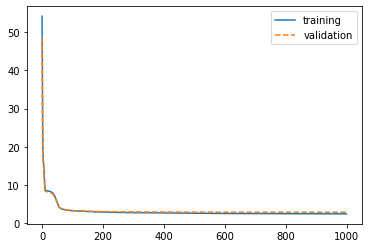

In [17]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(2,5)
# plt.xlim(0,500)
plt.legend()
plt.show()

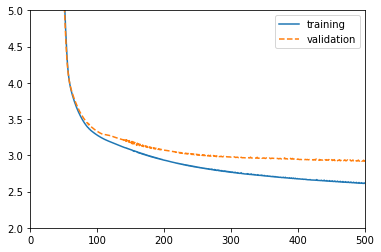

In [19]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,5)
plt.xlim(0,500)
plt.legend()
plt.show()

In [20]:
prova = nett.predict(Xval)

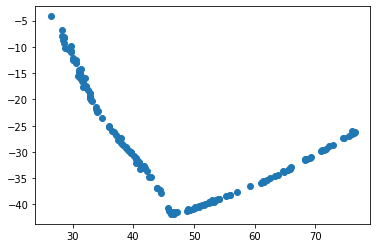

In [21]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

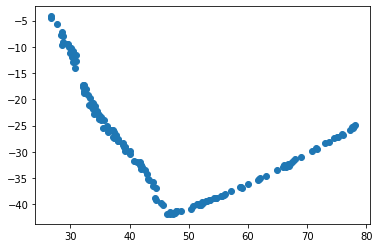

In [22]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

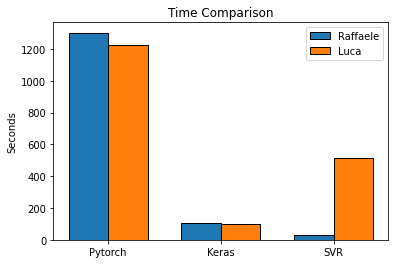

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Pytorch' , 'Keras', 'SVR']
raffaele_tempo = [1303.04, 108.66, 1.96]
luca_tempo = [1222.90, 99.40, 512]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, raffaele_tempo, width, edgecolor='black', label='Raffaele')
rects2 = ax.bar(x + width/2, luca_tempo, width, edgecolor='black', label='Luca')

ax.set_ylabel('Seconds')
ax.set_title('Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()